## Part 1. Scope Project & Gather Data


In [ ]:
import psycopg
import pandas as pd

# define the connection parameters
dbname = 'NA'
user = 'NA'
password = "NA"
host = 'NA'
port = 'NA' # this is the postgres port

# create a connection
connection = psycopg.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)
cursor = connection.cursor()
# execute a query
cursor.execute("SELECT * FROM mlds422.movies;")
result = cursor.fetchall()

# add column names
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(result, columns=column_names)
df.head()
df.to_pickle('movies.pkl')

## Part 2. Data Cleaning & Exploratory Data Analysis


### 1. Find the number of movies that were released in theatres each year

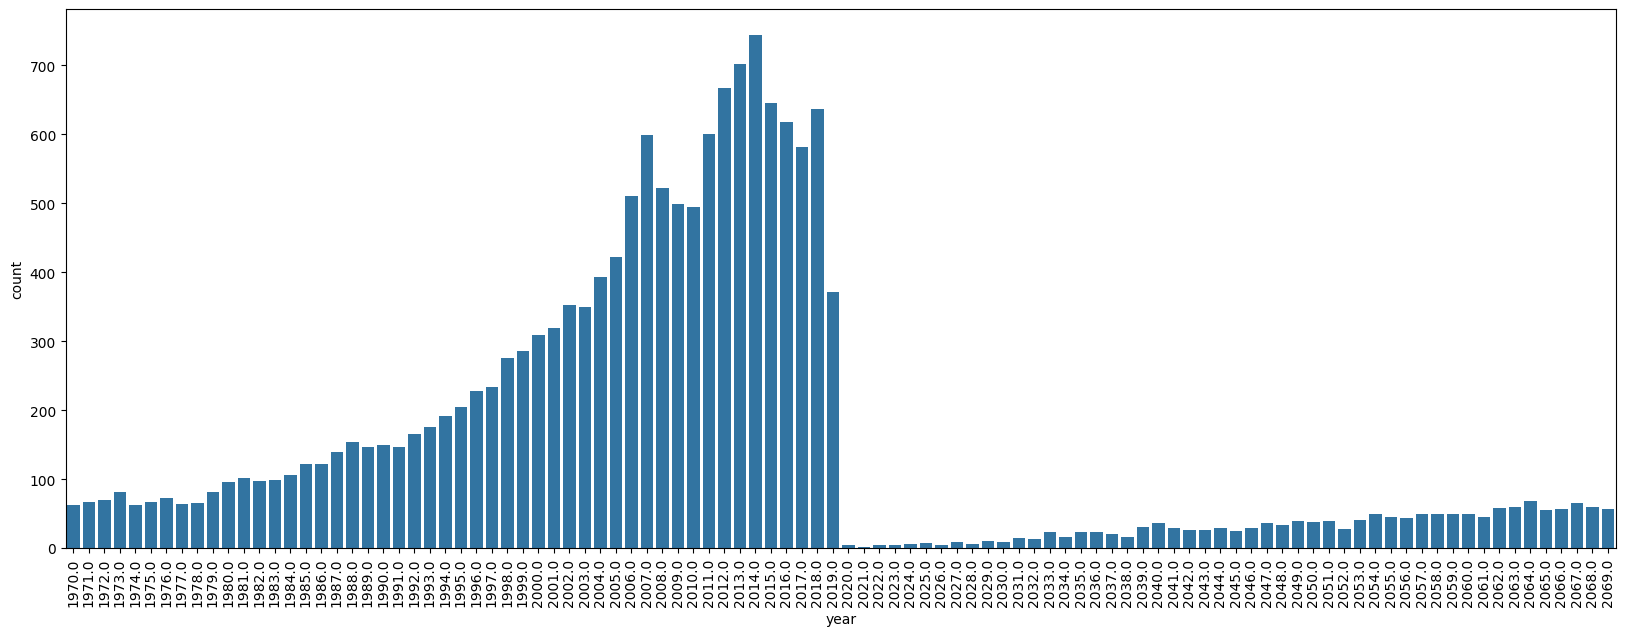

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# read the data
with open ('movies.pkl', 'rb') as f:
    df1 = pd.read_pickle(f)

# convert the date columns to datetime
df1['in_theaters_date'] = pd.to_datetime(df1['in_theaters_date'])
df1['on_streaming_date'] = pd.to_datetime(df1['on_streaming_date'])

# create a new column for the year
df1['year'] = df1['in_theaters_date'].dt.year

# group by year and count the number of movies
mv_yr = df1.groupby('year').size().reset_index(name = 'count')

# plot the number of movies by year
plt.figure(figsize=(20, 7))
sns.barplot(x='year', y='count', data=mv_yr)
plt.xticks(rotation=90)
plt.show()

In [113]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_id            16638 non-null  int64         
 1   movie_title         16638 non-null  object        
 2   movie_info          16614 non-null  object        
 3   rating              11776 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   in_theaters_date    15823 non-null  datetime64[ns]
 7   on_streaming_date   16636 non-null  datetime64[ns]
 8   runtime_in_minutes  16483 non-null  float64       
 9   critic_rating       16638 non-null  int64         
 10  critic_count        16638 non-null  int64         
 11  audience_rating     16381 non-null  float64       
 12  audience_count      16386 non-null  float64       
 13  year                15823 non-null  float64   

#### Review of the Plot for Number of Movies Released Each Year

- Upon reviewing the plot for the number of movies released each year, it appears that the number of movies for years greater than 2019 seems incorrect. 
- This discrepancy may be due to erroneous values in the data. By subtracting 100 years from the movie release dates that are greater than 2019, we can correct the erroneous values and ensure that these movies are correctly placed in the 20th century instead of the 21st century.


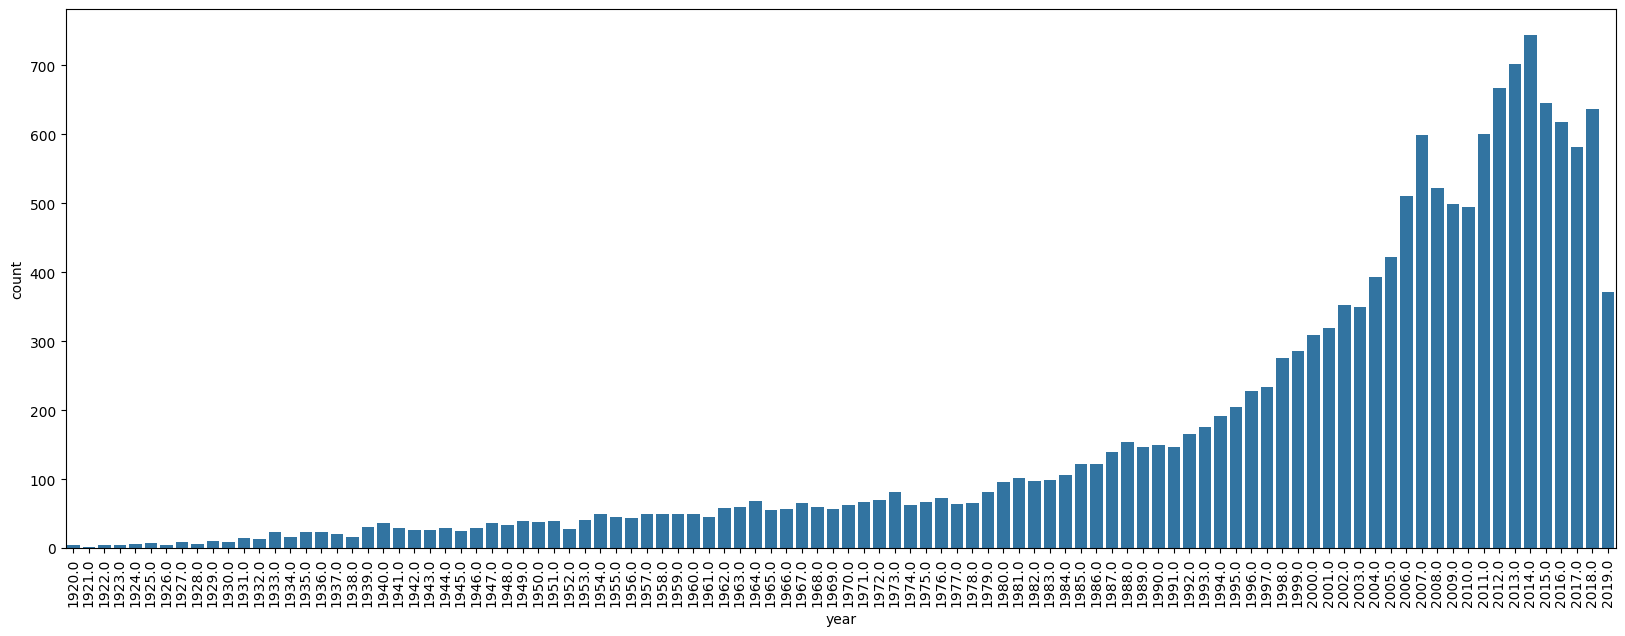

In [114]:
# Correct the years for movies released after 2019
df1.loc[df1['in_theaters_date'].dt.year > 2019, 'in_theaters_date'] -= pd.DateOffset(years=100)

# Recalculate the 'year' column
df1['year'] = df1['in_theaters_date'].dt.year

# Group by year and count the number of movies
mv_yr = df1.groupby('year').size().reset_index(name='count')

# Plot the number of movies released each year
plt.figure(figsize=(20, 7))
sns.barplot(x='year', y='count', data=mv_yr)
plt.xticks(rotation=90)
plt.show()

### 2. Looking only at movies that were released in theatres before 2010: 

In [115]:
# Filter movies released before 2010
movies_before_2010 = df1[df1['in_theaters_date'].dt.year < 2010]

# Find the 5 highest rated movies by critics
top_critics = movies_before_2010.nlargest(5, 'critic_rating')[['movie_title', 'critic_rating']]

# Find the 5 highest rated movies by audience
top_audience = movies_before_2010.nlargest(5, 'audience_rating')[['movie_title', 'audience_rating']]

# Display the results
print("Top 5 Movies by Critics:")
print(top_critics)

print("\nTop 5 Movies by Audience:")
print(top_audience)

Top 5 Movies by Critics:
                        movie_title  critic_rating
3   12 Angry Men (Twelve Angry Men)            100
14               The Breaking Point            100
15                       Adam's Rib            100
17    The Prowler (Cost of Living )            100
21     The Adventures of Robin Hood            100

Top 5 Movies by Audience:
                movie_title  audience_rating
222         Prima Ballerina            100.0
1283   La Ciudad (The City)            100.0
1846             Ice People            100.0
3229  Been Rich All My Life            100.0
6747          The Godfather             98.0


### 3. Create a new DataFrame containing only “popular” movies that were released in theatres before 2010. 

In [116]:
import pandas as pd
import numpy as np

# Filter movies released before 2010
movies_before_2010 = df1[df1['in_theaters_date'].dt.year < 2010]

# Calculate the average number of audience reviews
average_audience_reviews = movies_before_2010['audience_count'].mean()

# Create a new DataFrame containing only popular movies
popular_movies_before_2010 = movies_before_2010[movies_before_2010['audience_count'] > average_audience_reviews]

# Find the 5 highest rated movies by critics
popular_top_critics = popular_movies_before_2010.nlargest(5, 'critic_rating')[['movie_title', 'critic_rating']]

# Find the 5 highest rated movies by audience
popular_top_audience = popular_movies_before_2010.nlargest(5, 'audience_rating')[['movie_title', 'audience_rating']]

# Display the results
print("Top 5 Popular Movies by Critics:")
print(popular_top_critics)

print("\nTop 5 Popular Movies by Audience:")
print(popular_top_audience)

Top 5 Popular Movies by Critics:
          movie_title  critic_rating
9636     Mary Poppins            100
11227       Pinocchio            100
13557  The Terminator            100
15439       Toy Story            100
15440     Toy Story 2            100

Top 5 Popular Movies by Audience:
                                          movie_title  audience_rating
6747                                    The Godfather             98.0
12463                        The Shawshank Redemption             98.0
851                                        GoodFellas             97.0
4435                     Cidade de Deus (City of God)             97.0
5706   Star Wars: Episode V - The Empire Strikes Back             97.0


### 4. Using your new DataFrame (popular movies released in theatres before 2010): 

In [117]:
# Calculate the percentage of movies with each rating
rating_percentage = popular_movies_before_2010['rating'].value_counts(normalize=True).reset_index(name='percentage')
rating_percentage.columns = ['rating', 'percentage']
rating_percentage

,rating,percentage
0,PG-13,0.415832
1,R,0.323647
2,PG,0.196393
3,G,0.064128


The majority of movies fall under the PG-13 rating, followed by R, PG, and G ratings. This indicates that most movies are targeted towards a teenage and adult audience, with fewer movies being made specifically for children (G rating).

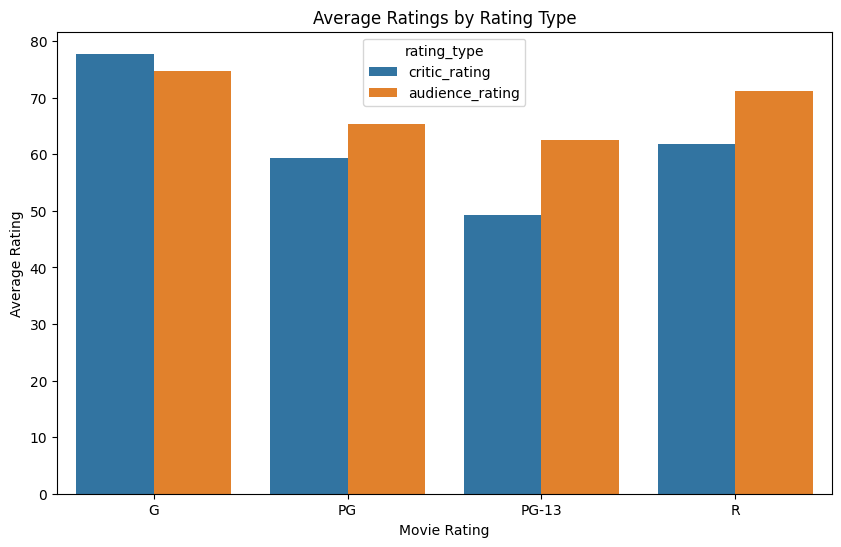

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average ratings for each rating type
average_ratings = popular_movies_before_2010.groupby('rating').agg({
    'critic_rating': 'mean',
    'audience_rating': 'mean'
}).reset_index()

# Plotting Critic and Audience Ratings
plt.figure(figsize=(10, 6))
average_ratings_melted = average_ratings.melt(id_vars='rating', value_vars=['critic_rating', 'audience_rating'], var_name='rating_type', value_name='average_rating')
sns.barplot(x='rating', y='average_rating', hue='rating_type', data=average_ratings_melted)
plt.title('Average Ratings by Rating Type')
plt.xlabel('Movie Rating')
plt.ylabel('Average Rating')
plt.show()

The visualization below shows the average critic rating and average audience rating for each movie rating category. From the visualization, we can observe that:
- G-rated movies tend to have the highest average critic and audience ratings.
- PG-rated movies have lower average critic ratings compared to G-rated movies but still maintain relatively high audience ratings.
- PG-13 and PG-rated movies have lower average ratings from both critics and audiences compared to G and R-rated movies.

### 5. Create a pair plot of the new DataFrame. 

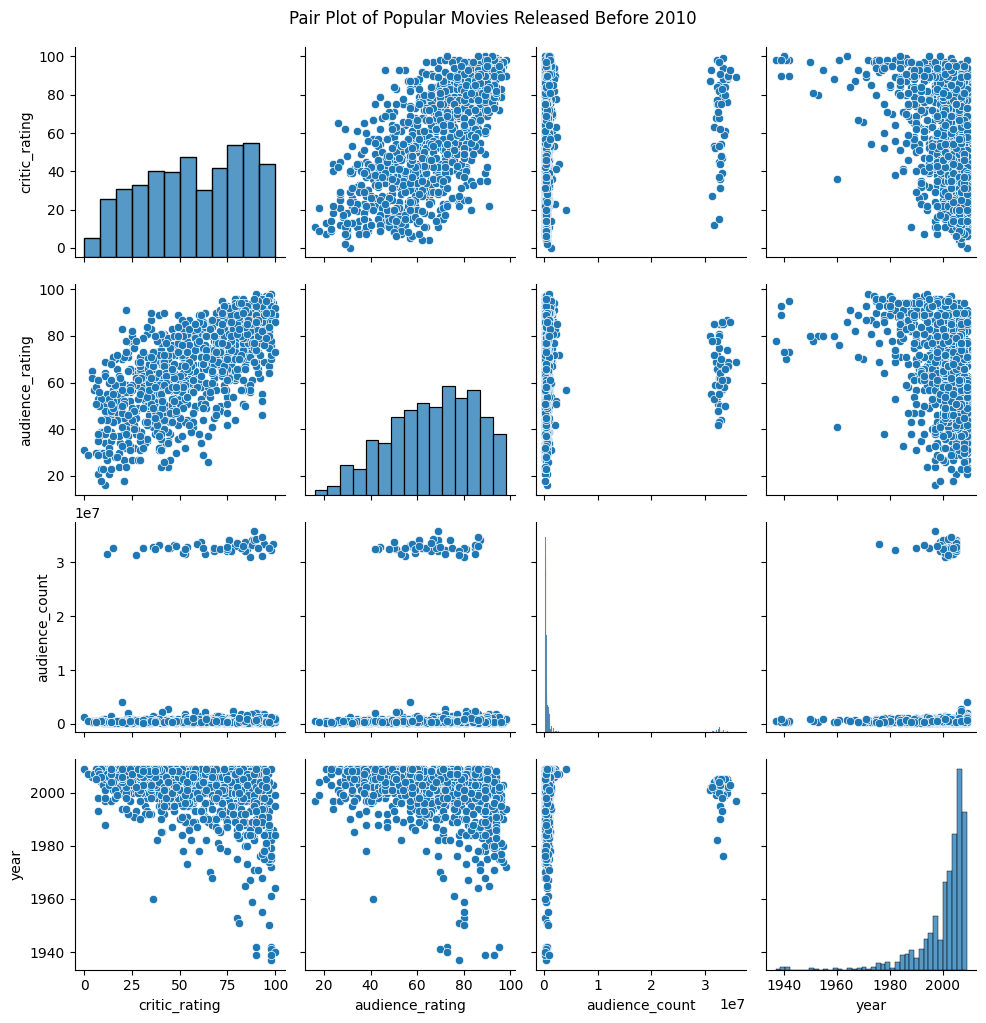

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pair plot for the DataFrame
sns.pairplot(popular_movies_before_2010, vars=['critic_rating', 'audience_rating', 'audience_count','year'])
plt.suptitle('Pair Plot of Popular Movies Released Before 2010', y=1.02)
plt.show()

#### Insight 1. Correlation Between Critic and Audience Ratings:
- There is a noticeable positive correlation between critic ratings and audience ratings. This suggests that movies well-received by critics tend to also be appreciated by audiences.

#### Insight 2. Distribution of Ratings:
- Both critic and audience ratings are fairly spread out, with a concentration of higher ratings. - This indicates that popular movies generally receive favorable reviews.

#### Insight 3. Audience Count vs. Ratings:
- The plot shows that most movies have relatively low audience counts, with a few exceptions. 
- This suggests that while some movies attract large audiences, many remain niche despite high ratings.

### 6. Using either pandas or data visualizations, find 3 more insights using any columns in the new DataFrame.

#### Insight 1: 
- This plot helps to understand how movie runtimes are distributed among popular movies released before 2010. 
- It shows the frequency of movies are around 100 minutes and lower frequency for shorter movie of below 60 minutes and longer movies above 150 minutes

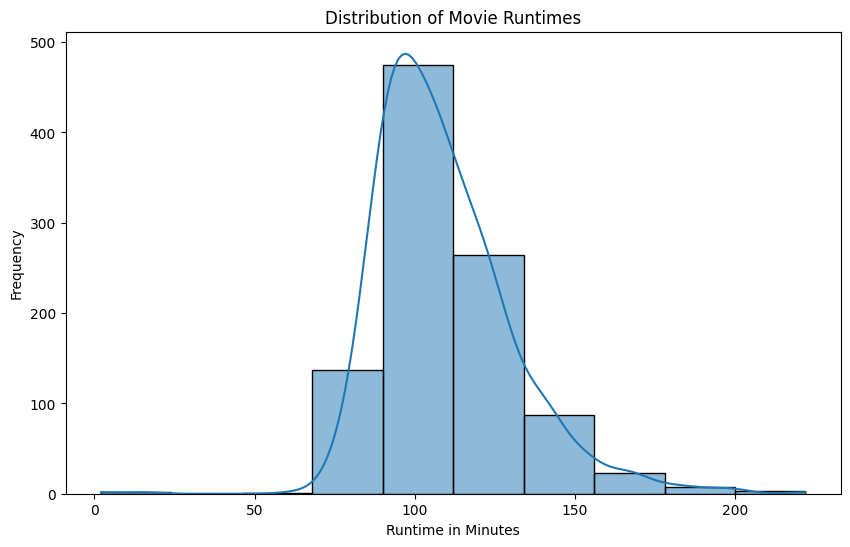

In [120]:
plt.figure(figsize=(10, 6))
sns.histplot(popular_movies_before_2010['runtime_in_minutes'], bins=10, kde=True)
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime in Minutes')
plt.ylabel('Frequency')
plt.show()


### Insight 2: 
- This plot helps to understand how the distribution of movie ratings has changed over different decades. 
- It shows the relative popularity of G-rating movie before 1960 but getting lower popularity after that when PG and R rated movies getting more popular

C:\Users\voqua\AppData\Local\Temp\ipykernel_14716\1316242311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_movies_before_2010['decade'] = (popular_movies_before_2010['year'] // 10) * 10


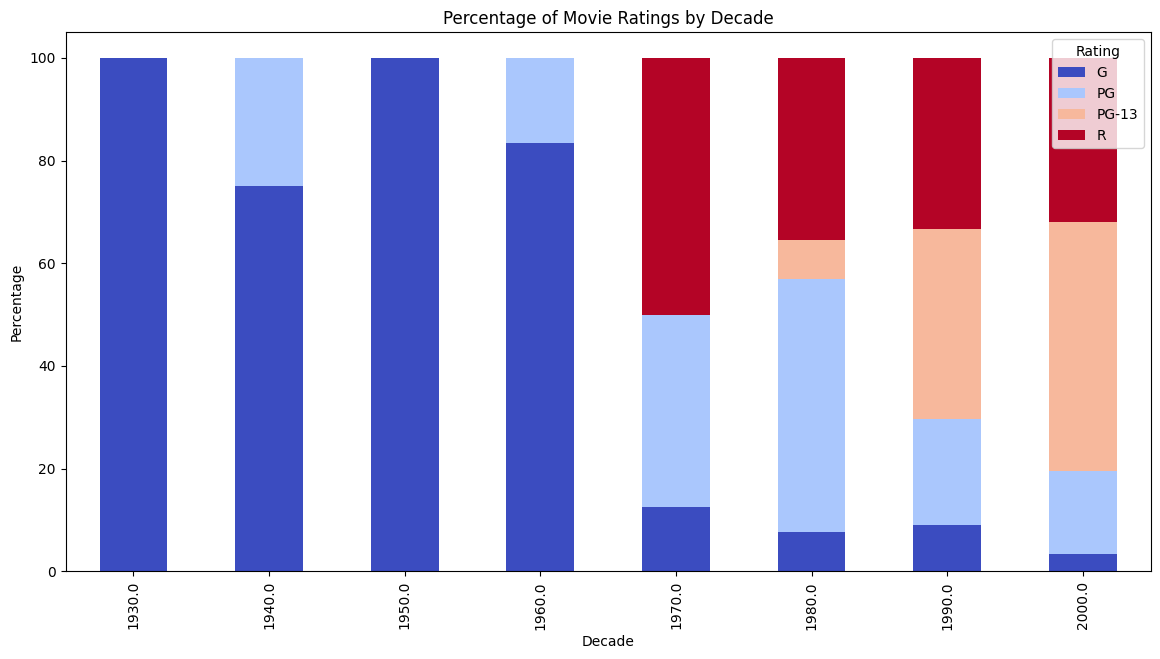

In [121]:
# Create a new column for the decade
popular_movies_before_2010['decade'] = (popular_movies_before_2010['year'] // 10) * 10

# Pivot table to calculate the percentage of each rating by decade
rating_percentage_by_decade = popular_movies_before_2010.pivot_table(index='decade', columns='rating', values='movie_id', aggfunc='count', fill_value=0)
rating_percentage_by_decade = rating_percentage_by_decade.div(rating_percentage_by_decade.sum(axis=1), axis=0) * 100

# Plot the percentage of each rating by decade
rating_percentage_by_decade.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='coolwarm')
plt.title('Percentage of Movie Ratings by Decade')
plt.xlabel('Decade')
plt.ylabel('Percentage')
plt.legend(title='Rating')
plt.show()


### Insight 3:
- This plot helps to understand the popularity of different movie genres among popular movies released before 2010. 
- It shows that comedy is the most popular genre then dram and Action& Adventure genres.

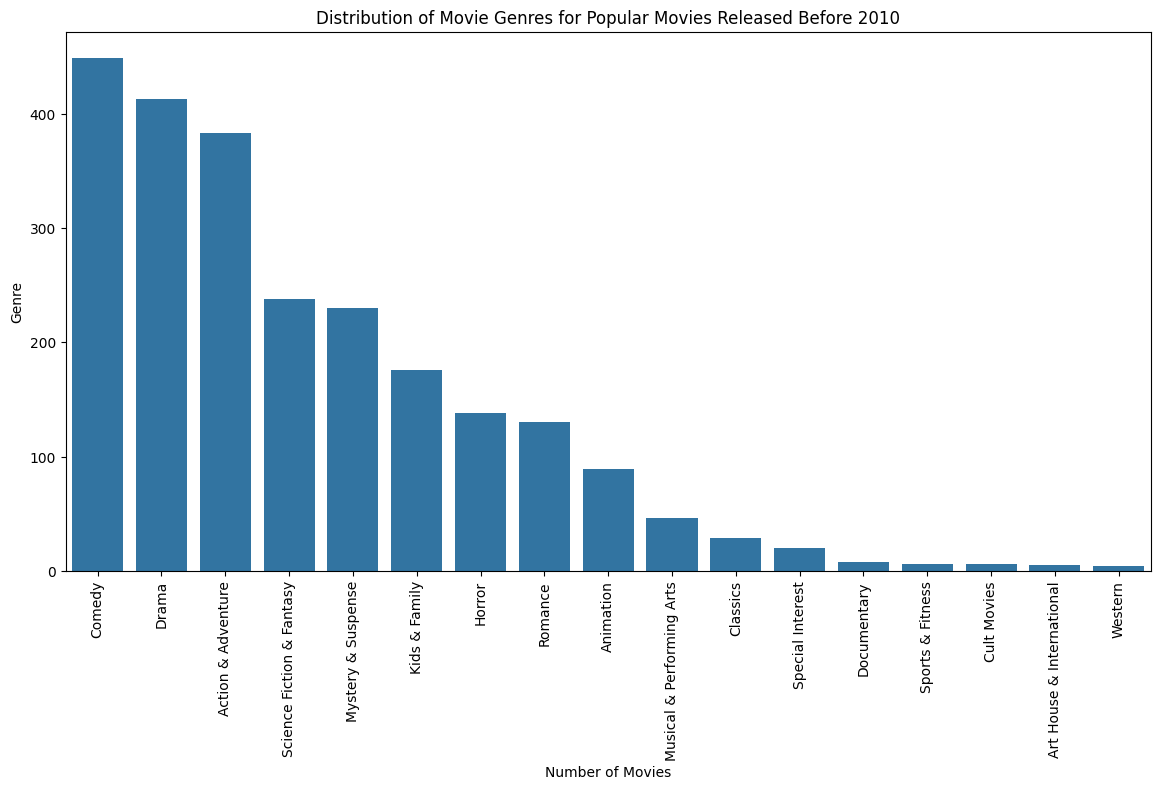

In [122]:
# Split the genres and explode the list to separate rows
df_genres = popular_movies_before_2010['genre'].str.split(', ').explode()
# Count the number of movies in each genre
genre_counts = df_genres.value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Plot the distribution of movie genres
plt.figure(figsize=(14, 7))
sns.barplot(x='genre', y='count', data=genre_counts)
plt.title('Distribution of Movie Genres for Popular Movies Released Before 2010')
plt.xlabel('Number of Movies')
plt.xticks(rotation=90)
plt.ylabel('Genre')
plt.show()

## Part 3. Feature Engineering

### 7. Split the data into a training and test set

In [123]:
# Split data into training and testing sets
train_data = df1[df1['in_theaters_date'].dt.year < 2010]
test_data = df1[df1['in_theaters_date'].dt.year >= 2010]

train_data.shape

(9764, 14)

### 8. Goal is to predict the critic_rating before the first critic or audience rating gets posted for a movie:

In [124]:
# Columns to exclude for predicting critic_rating
columns_to_exclude = ['critic_rating', 'audience_rating', 'audience_count', 'critic_count']

# Update training and test sets
train_data_features = train_data.drop(columns=columns_to_exclude)
test_data_features = test_data.drop(columns=columns_to_exclude)

To predict the critic_rating before any ratings are posted, we should not use columns that contain information about ratings or any other post-release data. These columns include:
- critic_rating
- audience_rating
- audience_count
- critic_count


### 9. Using only the training data, create a new DataFrame containing the following ID column and features: 
- movie_title 
- runtime_in_minutes 
- NEW: kid_friendly (1 if G or PG, 0 if other ratings) 
- NEW: dummy variable columns for each genre 

In [125]:
# Feature 0.1: kid-friendly
train_data_features['kid_friendly'] = train_data_features['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)
train_data_features.value_counts('kid_friendly')

kid_friendly
0    7646
1    2118
Name: count, dtype: int64

In [126]:
# Feature 0.2: genre_dummies

# Split the genres into lists
train_data_features['genre'] = train_data_features['genre'].str.split(', ')

# Explode the genre lists to separate rows
genre_exploded = train_data_features.explode('genre')[['movie_id','genre']]
genre_dummies = pd.get_dummies(genre_exploded, columns=['genre'])

genre_dummies = genre_dummies.groupby('movie_id').sum().reset_index()
genre_dummies

,movie_id,genre_Action & Adventure,genre_Animation,genre_Anime & Manga,genre_Art House & International,genre_Classics,genre_Comedy,genre_Cult Movies,genre_Documentary,genre_Drama,...,genre_Horror,genre_Kids & Family,genre_Musical & Performing Arts,genre_Mystery & Suspense,genre_Romance,genre_Science Fiction & Fantasy,genre_Special Interest,genre_Sports & Fitness,genre_Television,genre_Western
0,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,4,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,5,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,6,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,7,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9759,16633,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9760,16634,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
9761,16636,1,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9762,16637,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### 10. Create 3 new features:


In [127]:
# Feature 1: runtime_category

# Create a new column for runtime category
train_data_features['runtime_category'] = pd.cut(
    train_data_features['runtime_in_minutes'],
    bins=[0, 90, 120, 180, float('inf')],
    labels=['Short', 'Medium', 'Long', "Extra Long"]
)
runtime_dummies = pd.get_dummies(train_data_features[['movie_id','runtime_category']], columns=['runtime_category'] ,prefix='runtime').astype(int)
runtime_dummies

,movie_id,runtime_Short,runtime_Medium,runtime_Long,runtime_Extra Long
2,3,0,1,0,0
3,4,0,1,0,0
4,5,0,0,1,0
5,6,0,1,0,0
6,7,1,0,0,0
...,...,...,...,...,...
16631,16631,0,1,0,0
16633,16633,1,0,0,0
16635,16636,0,0,1,0
16636,16637,0,0,1,0


In [128]:
# Feature 2: seasonal_release (categorize by release season/ month)
train_data_features['seasonal_release'] = train_data_features['in_theaters_date'].dt.month 
train_data_features.value_counts('seasonal_release')

seasonal_release
1     1334
12     954
10     930
6      905
9      836
8      787
4      734
11     728
3      711
5      642
7      616
2      587
Name: count, dtype: int64

In [129]:
# Feature 3: director_popularity
# Count the number of movies each director has directed
director_counts = train_data_features['directors'].value_counts().reset_index()
director_counts.columns = ['directors', 'director_popularity']

# Merge the director popularity back into the training data
train_data_features = train_data_features.merge(director_counts, on='directors', how='left')
train_data_features['director_popularity']

0       27.0
1       29.0
2       16.0
3        8.0
4       36.0
        ... 
9759     4.0
9760     4.0
9761     NaN
9762     2.0
9763     3.0
Name: director_popularity, Length: 9764, dtype: float64

## Part 4. Modeling


### 11. Make sure you apply the same transformations on your X_test and y_test data sets

In [130]:
# Kid-friendly column: 1 if G or PG, 0 otherwise
test_data_features['kid_friendly'] = test_data_features['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)

# Split the genres into lists
test_data_features['genre'] = test_data_features['genre'].str.split(', ')
genre_exploded_test = test_data_features.explode('genre')[['movie_id', 'genre']]
genre_dummies_test = pd.get_dummies(genre_exploded_test, columns=['genre'])
genre_dummies_test = genre_dummies_test.groupby('movie_id').sum().reset_index()

# Feature 1: runtime_category
test_data_features['runtime_category'] = pd.cut(
    test_data_features['runtime_in_minutes'],
    bins=[0, 90, 120, 180, float('inf')],
    labels=['Short', 'Medium', 'Long', "Extra Long"])
runtime_dummies_test = pd.get_dummies(test_data_features[['movie_id', 'runtime_category']], columns=['runtime_category'], prefix='runtime').astype(int)

# Feature 2: seasonal_release (categorize by release month)
test_data_features['seasonal_release'] = test_data_features['in_theaters_date'].dt.month 

# Feature 3: director_popularity
director_counts = test_data_features['directors'].value_counts().reset_index()
director_counts.columns = ['directors', 'director_popularity']
# Merge the director popularity back into the testing data
test_data_features = test_data_features.merge(director_counts, on='directors', how='left')
test_data_features['director_popularity']

0       2.0
1       3.0
2       2.0
3       1.0
4       4.0
       ... 
6054    1.0
6055    1.0
6056    1.0
6057    2.0
6058    1.0
Name: director_popularity, Length: 6059, dtype: float64

### 12. Make sure that your X_train, y_train, X_test and y_test data sets only contain columns of numeric and non-null values. 

In [131]:
# Drop rows with missing values in genre, kid_friendly, seasonal_release, runtime_category, runtime_in_minutes
train_data_features = train_data_features.dropna(subset=['director_popularity','genre','kid_friendly', 'seasonal_release', 'runtime_category','runtime_in_minutes'])
train_data_features[['director_popularity','genre','kid_friendly', 'seasonal_release', 'runtime_category','runtime_in_minutes']].isna().sum()

director_popularity    0
genre                  0
kid_friendly           0
seasonal_release       0
runtime_category       0
runtime_in_minutes     0
dtype: int64

In [132]:
# Drop rows with missing values in test set
test_data_features = test_data_features.dropna(subset=['director_popularity','genre','kid_friendly', 'seasonal_release', 'runtime_category','runtime_in_minutes'])
test_data_features[['director_popularity','genre','kid_friendly', 'seasonal_release', 'runtime_category','runtime_in_minutes']].isna().sum()

director_popularity    0
genre                  0
kid_friendly           0
seasonal_release       0
runtime_category       0
runtime_in_minutes     0
dtype: int64

#### Dropping Rows with Missing Values: 
- I drop rows with missing values in the specified columns (director_popularity, genre, kid_friendly, seasonal_release, runtime_category, runtime_in_minutes) because these columns are essential for features. For genre column, as dropping the NA in it will make sure there will be no NA in the genre dummies that we will use later.
- Drop the NA in runtime_in_minutes will also ensure that the runtime_category that I engineered will have no NA after merge with this train or test features.

#### Selecting Numeric Columns: 
- I select only numeric columns for your features to ensure that the model can process the data correctly. Non-numeric columns (e.g., genre) need to be encoded or transformed before they can be used in the model

### 13. Fit 3 linear regression models on the training data: 
- Model 1: Use only runtime_in_minutes 
- Model 2: Use runtime_in_minutes and kid_friendly 
- Model 3: Use runtime_in_minutes, kid_friendly and the dummy columns 
for the genres

In [133]:
# Make sure the movie_id is in both the features and targets
Y_train = train_data.loc[train_data['movie_id'].isin(train_data_features.movie_id),'critic_rating']
Y_test = test_data.loc[test_data['movie_id'].isin(test_data_features.movie_id),'critic_rating']

In [134]:
from sklearn.linear_model import LinearRegression

# Model 1: Use only runtime_in_minutes  
X_train1 = train_data_features[['runtime_in_minutes']]
X_test1 = test_data_features[['runtime_in_minutes']]

# Model 1: Use only runtime_in_minutes
model1 = LinearRegression()
model1.fit(X_train1, Y_train)

LinearRegression()

In [135]:
# Model 2: Use runtime_in_minutes and kid_friendly 
X_train2 = train_data_features[['runtime_in_minutes','kid_friendly']]
X_test2 = test_data_features[['runtime_in_minutes','kid_friendly']]

# Model 2: Use runtime_in_minutes and kid_friendly
model2 = LinearRegression()
model2.fit(X_train2, Y_train)

LinearRegression()

In [136]:
# Model 3: Use runtime_in_minutes and kid_friendly 
X_train3 = train_data_features[['movie_id','runtime_in_minutes','kid_friendly']].merge(genre_dummies, on = 'movie_id').drop(columns = 'movie_id')
X_test3 = test_data_features[['movie_id','runtime_in_minutes','kid_friendly']].merge(genre_dummies_test, on = 'movie_id').drop(columns = 'movie_id')

# Model 3: Use runtime_in_minutes, kid_friendly, and the dummy columns for the genres
model3 = LinearRegression()
model3.fit(X_train3, Y_train)

LinearRegression()

### 14. Score the linear regression models on the test data:

In [137]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, mae, rmse

# Model 1
y_pred1 = model1.predict(X_test1)
r2_1, mae_1, rmse_1 = evaluate_model(Y_test, y_pred1)
print(f"Model 1 - R2: {r2_1}, MAE: {mae_1}, RMSE: {rmse_1}")

# Model 2
y_pred2 = model2.predict(X_test2)
r2_2, mae_2, rmse_2 = evaluate_model(Y_test, y_pred2)
print(f"Model 2 - R2: {r2_2}, MAE: {mae_2}, RMSE: {rmse_2}")

# Model 3
y_pred3 = model3.predict(X_test3)
r2_3, mae_3, rmse_3 = evaluate_model(Y_test, y_pred3)
print(f"Model 3 - R2: {r2_3}, MAE: {mae_3}, RMSE: {rmse_3}")

Model 1 - R2: 0.0014794653611993613, MAE: 24.331256868028962, RMSE: 28.258249957451053
Model 2 - R2: 0.0008521513094904565, MAE: 24.372430943999387, RMSE: 28.26712509489091
Model 3 - R2: 0.1477850307394396, MAE: 22.036340163774256, RMSE: 26.106060565730107


### 15. Which model performs the best so far?  

In [138]:
import statsmodels.api as sm

# Reset index for Y_train and X_train3_const
Y_train = Y_train.reset_index(drop=True)
X_train1_const = X_train1.reset_index(drop=True)

# Add a constant to the model (intercept)
X_train1_const = sm.add_constant(X_train1_const)

# Fit the model
model1_sm = sm.OLS(Y_train, X_train1_const).fit()

# Print the summary
print(model1_sm.summary())

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     95.21
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           2.17e-22
Time:                        20:15:44   Log-Likelihood:                -46424.
No. Observations:                9732   AIC:                         9.285e+04
Df Residuals:                    9730   BIC:                         9.287e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 50.0612      1

In [139]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Reset index for Y_train and X_train3_const
X_train2_const = X_train2.reset_index(drop=True)

# Add a constant to the model (intercept)
X_train2_const = sm.add_constant(X_train2_const)

# Fit the model
model2_sm = sm.OLS(Y_train, X_train2_const).fit()

# Print the summary
print(model2_sm.summary())
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train2.columns
vif_data["VIF"] = [variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])]

print(vif_data)

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     54.26
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           3.69e-24
Time:                        20:15:44   Log-Likelihood:                -46417.
No. Observations:                9732   AIC:                         9.284e+04
Df Residuals:                    9729   BIC:                         9.286e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 49.4692      1

In [140]:
import statsmodels.api as sm

# Reset index for Y_train and X_train3_const
Y_train = Y_train.reset_index(drop=True)
X_train3_const = X_train3.reset_index(drop=True)

# Add a constant to the model (intercept)
X_train3_const = sm.add_constant(X_train3_const)

# Fit the model
model3_sm = sm.OLS(Y_train, X_train3_const).fit()

# Print the summary
print(model3_sm.summary())

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     124.9
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:15:44   Log-Likelihood:                -45210.
No. Observations:                9732   AIC:                         9.047e+04
Df Residuals:                    9708   BIC:                         9.064e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

#### Best Performing Model: 
- Based on the performance metrics, Model 3 performs the best with highest R2, lowest MAE and RMSE.

#### Significant Features:
- runtime_in_minutes: is always significant with a p-value much less than 0.05 in all three models.
- kid_friendly: is significant in Model 2 and Model 3. But the in Model 2 when adding kid_friendly, the model performed worse than Model 1. Eventhough the VIF is not significant, kid_friendly might overfit the train model which make it works worse on the test dataset.
- Other genre categories are also significant in predicting the critic_rating in Model 3

#### Analyze of features:
- runtime_in_minutes: For each additional minute of runtime, the critic_rating increases by 0.074 points, holding other variables constant.
- kid_friendly: Kid-friendly movies have a critic_rating that is 2.838 points higher on average, holding other variables constant.
- genre_Action & Adventure: Action & Adventure movies have a critic_rating that is 5.441 points lower on average, holding other variables constant.
- genre_Animation: Animation movies have a critic_rating that is 12.0066 points higher on average, holding other variables constant.
- There are other significant genre predictors except for genre_Anime & Manga and genre_Cult Movies

### 16. Fit 3 more linear regression models with new engineered features

In [141]:
# Model 4: Add on seasonal_release
X_train4 = train_data_features[['movie_id', 'runtime_in_minutes', 'seasonal_release','kid_friendly']].merge(genre_dummies, on='movie_id').drop(columns='movie_id')
X_test4 = test_data_features[['movie_id', 'runtime_in_minutes', 'seasonal_release','kid_friendly']].merge(genre_dummies_test, on='movie_id').drop(columns='movie_id')

# Fit the model
model4 = LinearRegression()
model4.fit(X_train4, Y_train)

# Evaluate the model
y_pred4 = model4.predict(X_test4)
r2_4, mae_4, rmse_4 = evaluate_model(Y_test, y_pred4)
print(f"Model 4 - R2: {r2_4}, MAE: {mae_4}, RMSE: {rmse_4}")

Model 4 - R2: 0.1488200842041809, MAE: 22.01124239443077, RMSE: 26.090202255909812


#### Adding seasonal_release: 
- The seasonal_release feature is added because the time of year a movie is released can impact its reception and critic ratings. 
- For example, movies released during holiday seasons or summer might have different audience expectations and critic reviews compared to those released in off-peak times.

#### Result: 
- Model 4 has an R² of 0.1488, MAE of 22.01, and RMSE of 26.09. 
- This indicates a moderate improvement in explaining the variance in critic_rating compared to previous models.

In [142]:
# Model 5: Add on runtime_category
X_train5 = train_data_features[['movie_id', 'runtime_in_minutes', 'seasonal_release','kid_friendly']].merge(genre_dummies, on='movie_id').merge(runtime_dummies, on='movie_id').drop(columns='movie_id')
X_test5 = test_data_features[['movie_id', 'runtime_in_minutes', 'seasonal_release','kid_friendly']].merge(genre_dummies_test, on='movie_id').merge(runtime_dummies_test, on='movie_id').drop(columns='movie_id')

model5 = LinearRegression()
model5.fit(X_train5, Y_train)

# Evaluate the model 5
y_pred5 = model5.predict(X_test5)
r2_5, mae_5, rmse_5 = evaluate_model(Y_test, y_pred5)
print(f"Model 5 - R2: {r2_5}, MAE: {mae_5}, RMSE: {rmse_5}")

Model 5 - R2: 0.15406550855806878, MAE: 21.934929605748618, RMSE: 26.009687153258643


#### Adding runtime_category: 
- The runtime_category feature is added to capture the categorical aspect of movie runtimes (e.g., short, medium, long). 
- This can provide additional insights beyond the numeric runtime_in_minutes by grouping movies into meaningful categories that might have different critic ratings.

#### Result: 
- Model 5 has an R² of 0.1541, MAE of 21.93, and RMSE of 26.01. 
- This shows a slight improvement over Model 4, indicating that runtime_category adds some predictive power to the model.

In [143]:
# Model 6: Use runtime_in_minutes, kid_friendly, genre dummies, runtime_category, seasonal_release, and is_drama
X_train6 = train_data_features[['movie_id', 'runtime_in_minutes', 'kid_friendly', 'seasonal_release','director_popularity']].merge(genre_dummies, on='movie_id').merge(runtime_dummies, on='movie_id').drop(columns='movie_id')
X_test6 = test_data_features[['movie_id', 'runtime_in_minutes', 'kid_friendly', 'seasonal_release','director_popularity']].merge(genre_dummies_test, on='movie_id').merge(runtime_dummies_test, on='movie_id').drop(columns='movie_id')

model6 = LinearRegression()
model6.fit(X_train6, Y_train)

# Evaluate Model 6
y_pred6 = model6.predict(X_test6)
r2_6, mae_6, rmse_6 = evaluate_model(Y_test, y_pred6)
print(f"Model 6 - R2: {r2_6}, MAE: {mae_6}, RMSE: {rmse_6}")

Model 6 - R2: 0.14149439596421876, MAE: 22.20249129522721, RMSE: 26.20223451065118


#### Adding director_popularity: 
- The director_popularity feature is added because the popularity of a director can significantly influence a movie's reception and critic ratings. 
- Popular directors often have a track record of successful movies, which can positively impact critic ratings.

#### Result: 
- Model 6 has an R² of 0.1415, MAE of 22.20, and RMSE of 26.20. 
- This shows a slight decrease in performance compared to Model 5, indicating that director_popularity might not add significant predictive power in this context.

### 17. Out of the 6 models you created, which model performs the best? 

Best Performing Model
- Out of the 6 models created, Model 5 performs the best based on the evaluation metrics:
- Model 5: R² = 0.1541, MAE = 21.93, RMSE = 26.01

Significant Features
- The features that seem to do a good job predicting the critic_rating based on the p-values and their inclusion in the best performing model are:

- runtime_in_minutes: This feature is consistently significant across all models with a p-value much less than 0.05.
- kid_friendly: This feature is significant in Model 2, Model 3, and Model 5, indicating its importance in predicting critic_rating.
- genre categories: Various genre categories (e.g., genre_Action & Adventure, genre_Animation, genre_Art House & International, genre_Classics, genre_Comedy, genre_Documentary) are significant in predicting critic_rating in Model 3 and Model 5.
- seasonal_release: This feature was added in Model 4 and retained in Model 5, showing its relevance in predicting critic_rating.
- runtime_category: This feature was added in Model 5 and contributed to the slight improvement in performance.

### 18. List 3 other things you could to do at this point to try and improve your model. 


#### Feature Engineering:
- Interaction Terms: Create interaction terms between features to capture more complex relationships. For example, interactions between genre and seasonal_release might reveal how certain genres perform better in specific seasons.
- Polynomial Features: Add polynomial features to capture non-linear relationships between the features and the target variable.
- Additional Features: Include other potentially relevant features such as budget, cast_popularity, or marketing_spend if available.
Advanced Modeling Techniques:

#### Regularization: 
- Use regularization techniques like Ridge Regression, Lasso Regression, or Elastic Net to prevent overfitting and improve model generalization.

#### Ensemble Methods: 
- Implement ensemble methods such as Random Forest, Gradient Boosting, or XGBoost to improve predictive performance by combining multiple models.